In [96]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [97]:
ratings_path = "/Users/amitnarang/Downloads/ml-latest-small/ratings.csv"

In [98]:
df = pd.read_csv(ratings_path, sep = ',')
print(df)
n_users = max(df['userId'])
n_items = max(df['movieId'])
ratings = np.zeros((n_users, n_items))
print(ratings)
for row in df.itertuples():
    ratings[row.userId - 1, row.movieId - 1] = row.rating
print(ratings)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [99]:
# taken from ethen8181
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)
del ratings
train

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [100]:
class ALSModel:
    def __init__(self, l, num_features, n_iters):
        self.l = l
        self.num_features = num_features
        self.n_iters = n_iters
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.num_features))
        self.item_factors = np.random.random((self.n_item, self.num_features))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for i in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            if i == self.n_iters - 1:
                print(predictions)
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.num_features) * self.l
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse
        

In [101]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [102]:
als = ALSModel(n_iters = 100, num_features = 40, l = 0.01)

[[ 3.01584919e+00  7.03761958e-01  9.32923123e-01 ...  0.00000000e+00
   0.00000000e+00 -4.66165251e-02]
 [ 1.21037585e-01  4.66169999e-02  5.68496229e-02 ...  0.00000000e+00
   0.00000000e+00  1.30703778e-02]
 [ 3.37121563e-02  1.46594177e-02  5.57874374e-02 ...  0.00000000e+00
   0.00000000e+00 -1.23980449e-03]
 ...
 [ 1.75126135e+00  2.56531084e+00  2.99363499e+00 ...  0.00000000e+00
   0.00000000e+00  1.58009790e-02]
 [ 5.57267434e-01  4.96896384e-01  1.30707562e-01 ...  0.00000000e+00
   0.00000000e+00  1.81274689e-03]
 [ 5.60345787e+00 -1.21776760e-01 -3.45874283e-02 ...  0.00000000e+00
   0.00000000e+00  4.40058011e-02]]


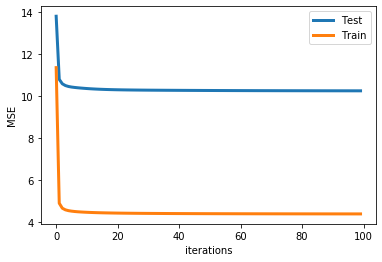

In [103]:
als.fit(train, test)
plot_learning_curve(als)

In [105]:
print(als.test_mse_record[-1])
print(als.train_mse_record[-1])

10.251992169875896
4.404787604174319
